# 0. Preps

### 0.1 Load modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
import cmocean 
import matplotlib.colors as colors
from matplotlib import cm
import datetime

### 0.2 Pre-set parameters for plotting

In [2]:
plt.rcParams.update({
    "font.weight": "normal",
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "lines.color": "k",
    "axes.titlesize": 18,
    "axes.titleweight": "normal",
    "axes.labelweight": "bold",
    "axes.labelsize": 18,
    "contour.linewidth": 0.8,
    "legend.fontsize": 14
})

### 0.3 Plotting functions

In [3]:
def warner_plot(x_axis,y_axis,var,tmin,tmax,cmap,it,name,label):
    '''
    This function plots a chosen variable in a z-x-section.
    _____________________________________________________________________
    
    x_axis ---> distance along x-axis
    y_axis ---> depth
    var    ---> chosen variable (e.g. salinity)
    tmin   ---> start value of the chosen variable for its normalization
    tmax   ---> stop value of the chosen variable for its normalization
    cmap   ---> choose predefined colormap
    label  ---> label of colormap
    _____________________________________________________________________
    '''
    fig, ax  = plt.subplots    (figsize=(8,6))                                                      # plot fig with one subplot
    norm_fld = colors.Normalize(vmin=tmin, vmax=tmax, clip=False)                                   # linearly normalizes data into [vmin,vmax] interval
    cs       = ax.pcolormesh   (x_axis,y_axis,var,norm=norm_fld,cmap=cmap)                          # plot variable with pcolormesh
    cbar     = plt.colorbar    (cs,orientation='horizontal',shrink=0.75,pad=0.2)                    # add colorbar
    xticks   = np.linspace     (tmin,tmax,num=5)                                                    # specify location of colorbar ticks
    timestamp = datetime.datetime(year=2001,month=1,day=1,hour=0,minute=0,second=0)
    timestamp += datetime.timedelta(seconds=int(time.data[it]))
    cbar.set_label(label)                                                                           # add colorbar label
    cbar.set_ticks(xticks)                                                                          # set colorbar ticks
    ax.set(title=str(timestamp),xlabel='Distance along x [m]',ylabel='Depth [m]',
           xlim=(0, 100000),ylim=(-15,1.5))                                                         # set axis labels and limits
    ax.tick_params(labeltop=False, labelright=False,direction = 'inout')                            # specify axis ticks
    plt.savefig(name+'_'+str(it)+'.png')

In [4]:
def basic_plot(time,var,varM,label):
    '''
    This function plots a chosen variable as a function of time,
    and, in addition, the variable's mean.
    _____________________________________________________________________
    
    time  ---> distance along x-axis
    var   ---> chosen variable 
    varM  ---> mean of chosen variable
    label ---> specify label for legend
    _____________________________________________________________________
    '''
    fig, ax  = plt.subplots(figsize=(6,4))                                             # plot fig with one subplot
    ax.plot  (time,var,label=label,color='darkslategrey')                              # plot the chosen variable as fct of time
    ax.hlines(varM,xmin=time[0],xmax=time[-1],label='mean '+label,color='firebrick')   # plot the mean of the chosen variable
    ax.legend(loc=1)                                                                   # add legend and specify its location

In [5]:
cmap_uu   = cm.get_cmap("RdBu_r")      # pre-defined colormap for zonal velocity
#cmap_salt = cm.get_cmap("GnBu_r")      # pre-defined colormap for salinity
cmap_salt = cmocean.cm.haline

# 1. Load file with resolved tidal data

In [6]:
path_file = '/home/henell/WORK/tools/GETM/setups/warner/warner.3d.nc'    # location of file
id_file   = netCDF4.Dataset(path_file, 'r')                              # read file

In [7]:
list_var = id_file.variables.keys()
print('\n Variables in the files:')
for cvar in list_var:
    nb_dim = len(id_file.variables[cvar].dimensions)
    print(' *** '+cvar+' -> has '+str(nb_dim)+' dimensions')
print('')


 Variables in the files:
 *** grid_type -> has 0 dimensions
 *** vert_cord -> has 0 dimensions
 *** ioff -> has 0 dimensions
 *** joff -> has 0 dimensions
 *** dx -> has 0 dimensions
 *** dy -> has 0 dimensions
 *** xc -> has 1 dimensions
 *** yc -> has 1 dimensions
 *** sigma -> has 1 dimensions
 *** bathymetry -> has 2 dimensions
 *** time -> has 1 dimensions
 *** elev -> has 3 dimensions
 *** u -> has 3 dimensions
 *** v -> has 3 dimensions
 *** hcc -> has 3 dimensions
 *** uu -> has 4 dimensions
 *** vv -> has 4 dimensions
 *** w -> has 4 dimensions
 *** salt -> has 4 dimensions
 *** sigma_t -> has 4 dimensions



In [8]:
j = 0                                         # j is set to zero since in this case our variables do not depend on yc
xc    = id_file.variables['xc'][:]            # xc [m]
time  = id_file.variables['time'][1:]         # time [s], seconds since 2000-01-01 00:00:00
                                              # exclude initial tidal snapshot (avoid double-counting during tidal averaging)
sigma = id_file.variables['sigma'][:]         # depth in sigma coordinates
elev  = id_file.variables['elev'][:,j,:]      # elevation [m] (is equal to eta)
salt  = id_file.variables['salt'][:,:,j,:]    # salinity [PSU]
u     = id_file.variables['u'][1:,j,:]        # int. zonal vel. [m/s] 
uu    = id_file.variables['uu'][:,:,j,:]      # zonal vel. [m/s]
bathy = id_file.variables['bathymetry'][j,:]  # bathymetry [m] (is equal to H)
dx    = id_file.variables['dx'][:]            # grid spacing (x) [m]
dy    = id_file.variables['dy'][:]            # grid spacing (y) [m]
id_file.close()                               # close netCDF file

In [9]:
(Nt,Nk,Ni) = np.shape(salt[:,:,:])
print('\n Shape of the domain Nt, Nk, Ni = ',Nt,Nk,Ni)


 Shape of the domain Nt, Nk, Ni =  113 41 201


# 2. Compute $dz$

In [10]:
dz = np.empty( (Nt, Nk, Ni) )
for t in range(Nt):
    #for k in range(Nk-1):
    for k in range(1,Nk):
        for i in range(Ni):
            #dz[t,k,i] = ( sigma[k+1] - sigma[k-1] ) * ( bathy[i] + elev[t,i] )
            dz[t,k,i] = ( sigma[k] - sigma[k-1] ) * ( bathy[i] + elev[t,i] )

In [11]:
xx = ( xc[:-1] + xc[1:] ) / 2
zw = np.zeros_like(dz, subok=False)
zw[:,:,:] = np.cumsum(dz[:,:,:], axis=1)
zw = zw - bathy
zx = ( zw[:,:,:-1] + zw[:,:,1:] ) / 2
zx[:,:,0] = zw[:,:,1]
zx[:,:,-1] = zw[:,:,-2]

In [12]:
xx2d = np.resize(xx, zx[0,:,:].shape)

<ipython-input-3-a618fc01f2c7>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs       = ax.pcolormesh   (x_axis,y_axis,var,norm=norm_fld,cmap=cmap)                          # plot variable with pcolormesh


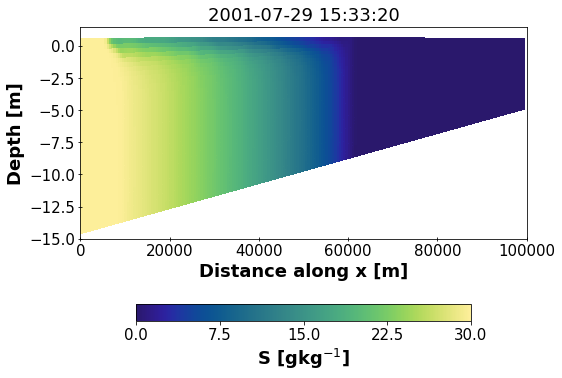

In [13]:
warner_plot(xx2d,zx[35,:,:],salt[35,:,:-1],0,30,cmap_salt,35,'salt','S [gkg$^{-1}$]')

<ipython-input-3-a618fc01f2c7>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs       = ax.pcolormesh   (x_axis,y_axis,var,norm=norm_fld,cmap=cmap)                          # plot variable with pcolormesh


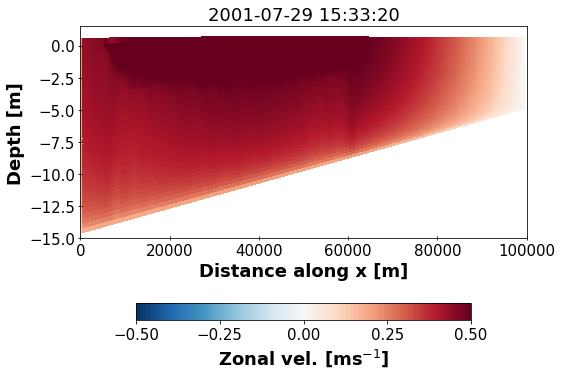

In [14]:
warner_plot(xx2d,zx[35,:,:],uu[35,:,:-1],-0.5,0.5,cmap_uu,35,'uu','Zonal vel. [ms$^{-1}$]')

In [15]:
#dz = np.empty( (Nk, Ni) )
#for k in range(Nk-1):
#    for i in range(Ni):
#        dz[k,i] = ( sigma[k+1] - sigma[k-1] ) * ( bathy[i] + elev[10,i] ) 
#        #print(dz[k,i])

# 3. Plot variable(s) in warner testcase

In [16]:
#warner_plot(xc,dz[25,1:,:],salt[25,1:-1,:-1],0,30,cmap_salt,'S [gkg$^{-1}$]')

# 4. Calculations

### Location of cross-section

In [17]:
i = 45 # (j = 0 was already defined at the beginning)

### Analyze water depth

In [18]:
xcl = xc[i]
xcr = xc[i+1]
xci = 0.5 * ( xcl + xcr ) # average to U-point interface between center cells
print( 'Analyze cross-section ', xci/1000, ' km upstream of open boundary.' )

Analyze cross-section  22.5  km upstream of open boundary.


In [19]:
bathyl = bathy[i]
bathyr = bathy[i+1]
bathyi = 0.5 * ( bathyl + bathyr ) # average to U-point interface between center cells

In [20]:
elevl = elev[:,i]
elevr = elev[:,i+1]
elevi = 0.25 * ( elevl[:-1] + elevl[1:] + elevr[:-1] + elevr[1:] ) # average in space and time

In [21]:
Di = bathyi + elevi # time-varying water depth
Di_mean = Di.mean() # mean water depth

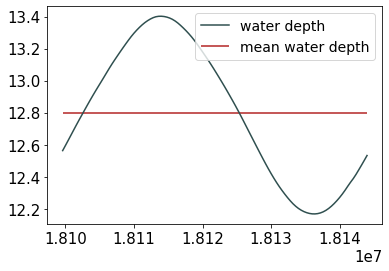

In [22]:
basic_plot(time,Di,Di_mean,'water depth')

### Analyze depth-averaged velocity

In [23]:
u2d = u[:,i] # time-varying depth-averaged velocity
u2d_mean = u2d.mean()
print( 'Mean depth-averaged velocity is <u2d> =', u2d_mean )

Mean depth-averaged velocity is <u2d> = -0.017449170351028442


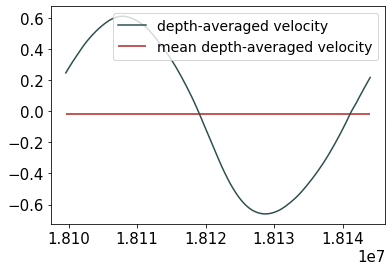

In [24]:
basic_plot(time,u2d,u2d_mean,'depth-averaged velocity')

### Analyze depth-integrated transport

In [25]:
Di_mean_u2d_mean = Di_mean * u2d_mean  
print( 'First guess for mean depth-integrated transport is dy*<D>*<u2d> = ', dy*Di_mean_u2d_mean )

First guess for mean depth-integrated transport is dy*<D>*<u2d> =  -111.63072684941255


In [26]:
Du2d = Di * u2d # time-varying depth-integrated transport
Du2d_mean = Du2d.mean()
print( 'Mean depth-integrated transport is dy*<D*u2d> =', dy*Du2d_mean )

Mean depth-integrated transport is dy*<D*u2d> = -51.95033550262451


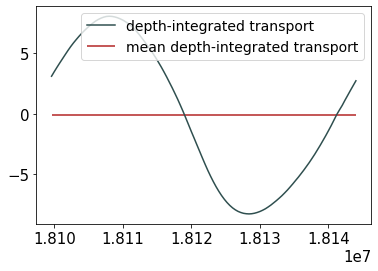

In [27]:
basic_plot(time,Du2d,Du2d_mean,'depth-integrated transport')

### Define mean transport velocity

In [28]:
#uu_M   = np.mean( dz*uu ) / np.mean( dz )
#flux_M = np.mean( dz*uu*salt ) / np.mean( dz )
#print(uu_M)
#print(flux_M)

In [29]:
u2d_twa = Du2d_mean / Di_mean
print( 'Mean depth-integrated transport velocity is <D*u2d>/<D> =', u2d_twa )
print( 'Mean depth-averaged velocity is <u2d> =', u2d_mean )

Mean depth-integrated transport velocity is <D*u2d>/<D> = -0.008120436725286326
Mean depth-averaged velocity is <u2d> = -0.017449170351028442


### 1$^{st}$ guess for Qin and Qout

In [30]:
Du2d_in  =  np.fmax( 0 , Du2d ) # only consider positive transports
Du2d_out = -np.fmin( Du2d , 0 ) # only consider negative transports
Du2d_in_mean  = Du2d_in.mean()
Du2d_out_mean = Du2d_out.mean()
print( 'First guess for Qin is dy*<(D*u2d)^+> =', dy*Du2d_in_mean )
print( 'First guess for Qout is -dy*<(D*u2d)^-> =', dy*Du2d_out_mean )

First guess for Qin is dy*<(D*u2d)^+> = 1272.9873657226562
First guess for Qout is -dy*<(D*u2d)^-> = 1324.9376841953822


### Check volume balance

In [31]:
t0 = time[ 0]
t1 = time[-1]
bathy1 = bathy[i+1:]
elev0 = elev[ 0,i+1:]
elev1 = elev[-1,i+1:]
D0 = bathy1 + elev0
D1 = bathy1 + elev1
V0 = D0.sum() * dx * dy
V1 = D1.sum() * dx * dy
print(' dV/dt =', ( V1 - V0 ) / ( t1 - t0 ) )
print(' Qin - Qout + Qr =', dy * ( Du2d_in_mean - Du2d_out_mean ) + 50 )

 dV/dt = 0.039554779996743075
 Qin - Qout + Qr = -1.950318472725911


==> Slightly non-periodic state dV/dt<>0 (could be avoided by averaging over more tidal cycles) !!!  
==> Volume balance is ok (single precision errors can be avoided with `-D_NCDF_SAVE_DOUBLE_`) !!!